# Kim2014 identification statistics

In [1]:
import os
import sys

src_dir = os.path.abspath('../src')
if src_dir not in sys.path:
    sys.path.append(src_dir)

In [2]:
%matplotlib inline
import functools

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm

from ann_solo import reader, spectrum, utils

In [3]:
# plot styling
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='serif')
sns.set_palette('Set1')
sns.set_context('paper', font_scale=1.)    # single-column figure

In [4]:
tqdm.tqdm = tqdm.tqdm_notebook

In [5]:
def extract_time_from_log(filename):
    with open(filename, 'r') as f_in:
        for line in f_in:
            if line.startswith('real'):
                # Wall clock time.
                realtime = line.split()[1]
                minutes = int(realtime[:realtime.find('m')])
                seconds = float(realtime[realtime.find('m') + 1:
                                         realtime.rfind('s')])
                realtime = minutes * 60 + seconds
                
                return realtime

In [6]:
max_fdr = 0.01
tol_mass = 0.1
tol_mode = 'Da'
min_group_size = 20

In [7]:
id_dir = '../../data/processed/kim2014/gpu'

In [8]:
ssms = []
num_ssms, num_peptides, runtimes = [], [], []
for filename in tqdm.tqdm(os.listdir(id_dir), desc='Files processed',
                          unit='files'):
    filename_full = os.path.join(id_dir, filename)
    filename_base, ext = os.path.splitext(filename)
    if ext == '.log':
        runtimes.append((os.path.splitext(filename)[0],
                         extract_time_from_log(filename_full)))
    elif ext == '.mztab':
        file_ssms = reader.read_mztab_ssms(filename_full)
        ssms.append(file_ssms)
        file_peptides = (file_ssms['sequence'].str.replace(r'n?\[\d+\]', '')
                         .unique())
        num_ssms.append((filename_base, len(file_ssms)))
        num_peptides.append((filename_base, len(file_peptides)))
        
ssms = pd.concat(ssms, ignore_index=True)

num_ssms_df = pd.DataFrame.from_records(num_ssms,
                                        columns=['filename', 'ssms'])
num_peptides_df = pd.DataFrame.from_records(num_peptides,
                                            columns=['filename', 'peptides'])
time_df = pd.DataFrame.from_records(runtimes, columns=['filename', 'time'])

stats = functools.reduce(
    lambda left, right: pd.merge(left, right, on='filename'),
    [num_ssms_df, num_peptides_df, time_df])
stats = stats.sort_values('filename').reset_index(drop=True)

In [9]:
print(f'Number of identified spectra: {stats["ssms"].sum():,.0f}\n'
      f'Total search time: {stats["time"].sum() / 3600:.0f} h '
      f'({stats["time"].sum() / 86400:.1f} days)\n'
      f'Search time per file: {stats["time"].mean() / 60:,.1f} '
      f'± {stats["time"].std() / 60:,.1f} min')

Number of identified spectra: 14,032,494
Total search time: 281 h (11.7 days)
Search time per file: 8.0 ± 3.1 min


In [10]:
num_ssm_unmod = num_ssm_total = 0
for filename in os.listdir(id_dir):
    filename_full = os.path.join(id_dir, filename)
    filename_base, ext = os.path.splitext(filename)
    if ext == '.log':
        with open(filename_full, 'r') as f_in:
            for line in f_in:
                if line.endswith('spectra identified after the standard search\n'):
                    start = line.find(' : ') + 3
                    end = line.find(' ', start)
                    num_ssm_unmod += int(line[start:end])
                if line.endswith('spectra identified after the open search\n'):
                    start = line.find(' : ') + 3
                    end = line.find(' ', start)
                    num_ssm_total += int(line[start:end])
num_ssm_mod = num_ssm_total - num_ssm_unmod

In [11]:
print(f'Total number of identified spectra: {num_ssm_total:,.0f}\n'
      f'Number of unmodified identified spectra: {num_ssm_unmod:,.0f}\n'
      f'Number of modified identified spectra: {num_ssm_mod:,.0f}\n')

Total number of identified spectra: 14,032,494
Number of unmodified identified spectra: 9,760,497
Number of modified identified spectra: 4,271,997



In [12]:
def get_mass_groups(ssms, tol_mass, tol_mode):
    ssms_remaining = ssms.sort_values('search_engine_score[1]',
                                      ascending=False)
    ssms_remaining['mass_diff'] = ((ssms_remaining['exp_mass_to_charge'] -
                                    ssms_remaining['calc_mass_to_charge']) *
                                   ssms_remaining['charge'])

    # Start with the highest ranked SSM.
    mass_groups = []
    while ssms_remaining.size > 0:
        # Find all remaining PSMs within the mass difference window.
        mass_diff = ssms_remaining['mass_diff'].iloc[0]
        if (tol_mass is None or tol_mode not in ('Da', 'ppm') or
                min_group_size is None):
            mask = np.full(len(ssms_remaining), True, dtype=bool)
        elif tol_mode == 'Da':
            mask = (np.fabs(ssms_remaining['mass_diff'] - mass_diff) <=
                    tol_mass)
        elif tol_mode == 'ppm':
            mask = (np.fabs(ssms_remaining['mass_diff'] - mass_diffs) /
                    ssms_remaining['exp_mass_to_charge'] * 10 ** 6
                    <= tol_mass)
        mass_groups.append(ssms_remaining[mask])
        # Exclude the selected SSMs from further selections.
        ssms_remaining = ssms_remaining[~mask]

    mass_group_stats = []
    for mass_group in mass_groups:
        mass_group_stats.append((mass_group['mass_diff'].median(),
                                 mass_group['mass_diff'].mean(),
                                 len(mass_group)))
    mass_group_stats = pd.DataFrame.from_records(
        mass_group_stats, columns=['mass_diff_median', 'mass_diff_mean',
                                   'num_ssms'])
    return mass_group_stats

In [13]:
mass_groups = get_mass_groups(ssms, tol_mass, tol_mode)

In [14]:
mass_groups.sort_values('num_ssms', ascending=False).head(10)

,mass_diff_median,mass_diff_mean,num_ssms
0,0.000646,0.001236,9882777
8,57.022315,57.022839,308387
21,27.995986,27.998766,246428
16,0.993853,0.987444,219006
11,15.995468,15.996442,211927
5,-0.986346,-0.999017,163269
7,14.015814,14.013037,133020
76,-17.025133,-17.019578,129687
54,-18.009568,-18.006636,111075
4,1.988133,1.989208,99286


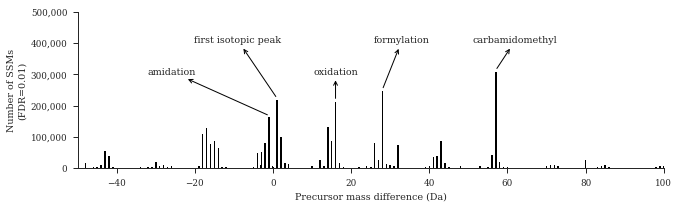

In [15]:
width = 7
height = width / 1.618
fig, ax = plt.subplots(figsize=(width * 1.5, height / 1.5))

# Exclude unmodified SSMs.
mask = mass_groups['mass_diff_median'].abs() > tol_mass
ax.bar(mass_groups[mask]['mass_diff_median'], mass_groups[mask]['num_ssms'],
       width=0.4, color='black')

# Annotate the most frequent modifications.
modifications = [('carbamidomethyl', 5, 400000), ('formylation', 5, 400000),
                 ('first isotopic peak', -10, 400000),
                 ('oxidation', 0, 300000), ('amidation', -25, 300000)]
for (annot, x, y), mass_group in zip(
        modifications, mass_groups.sort_values(
            'num_ssms', ascending=False).head(10)[1:].itertuples()):
    ax.annotate(annot,
                (mass_group.mass_diff_median, mass_group.num_ssms + 5000),
                (mass_group.mass_diff_median + x, y),
                arrowprops={'arrowstyle': '<-', 'linewidth': 1}, ha='center')

ax.set_xlim((-50, 100))
ax.set_ylim(0, 500000)

# Format y-axis numbers.
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,g}'))

sns.despine(ax=ax)

ax.set_xlabel('Precursor mass difference (Da)')
ax.set_ylabel(f'Number of SSMs\n(FDR={max_fdr})')

plt.savefig('mass_diff.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()